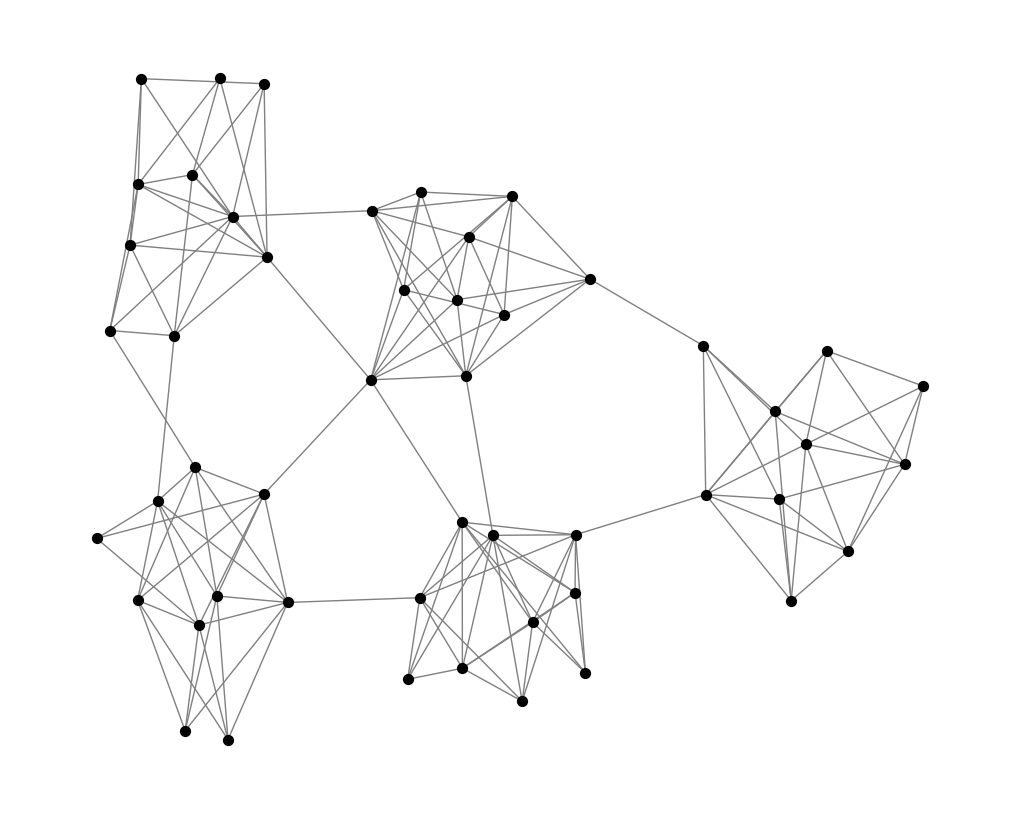

In [57]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
import networkx as nx
import torch_sparse
import warnings
warnings.filterwarnings('ignore')
# Lets create an sbm graph of 5 communities with 10 nodes each, where the probability of connection between communities is 0.02 and within communities is 0.5

G = nx.stochastic_block_model([10, 10, 10, 10, 10], [[0.6, 0.01, 0.01, 0.01, 0.01],
                                                    [0.01, 0.6, 0.01, 0.01, 0.01],
                                                    [0.01, 0.01, 0.6, 0.01, 0.01],
                                                    [0.01, 0.01, 0.01, 0.6, 0.01],
                                                    [0.01, 0.01, 0.01, 0.01, 0.6]],
                                                     seed=42)                       
# SHow the graph
plt.figure(figsize=(10, 8))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, node_size=50, node_color='black', edge_color='gray', with_labels=False)
plt.show()                                                

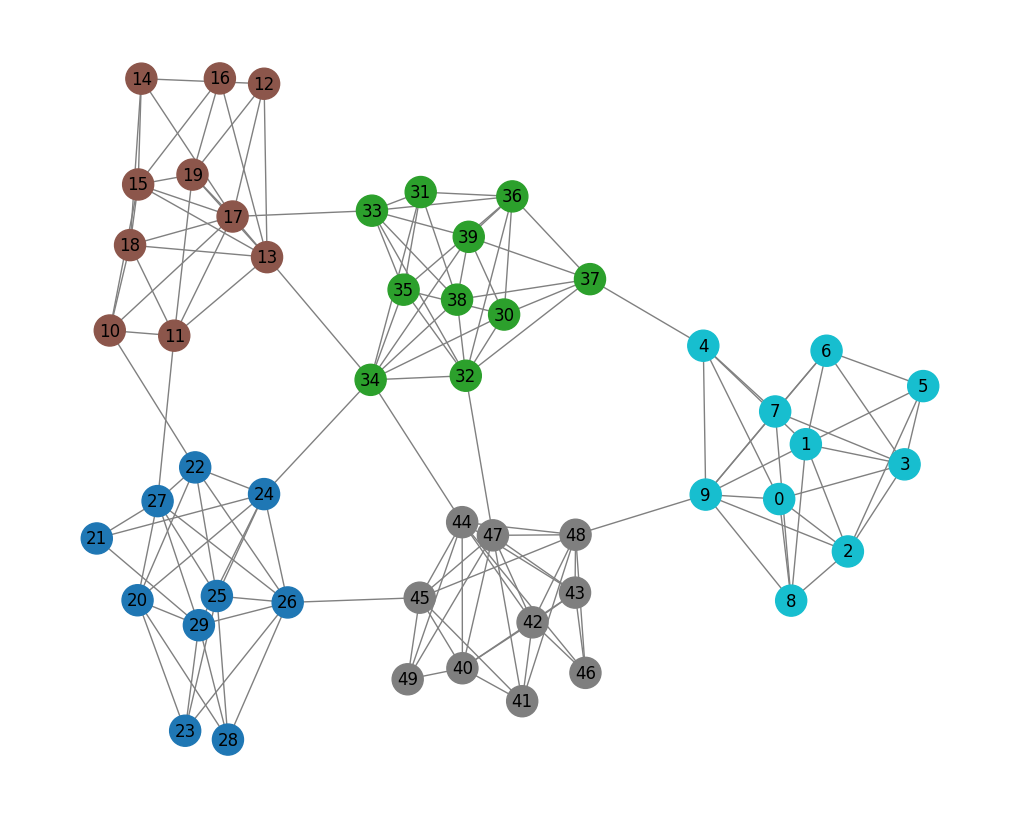

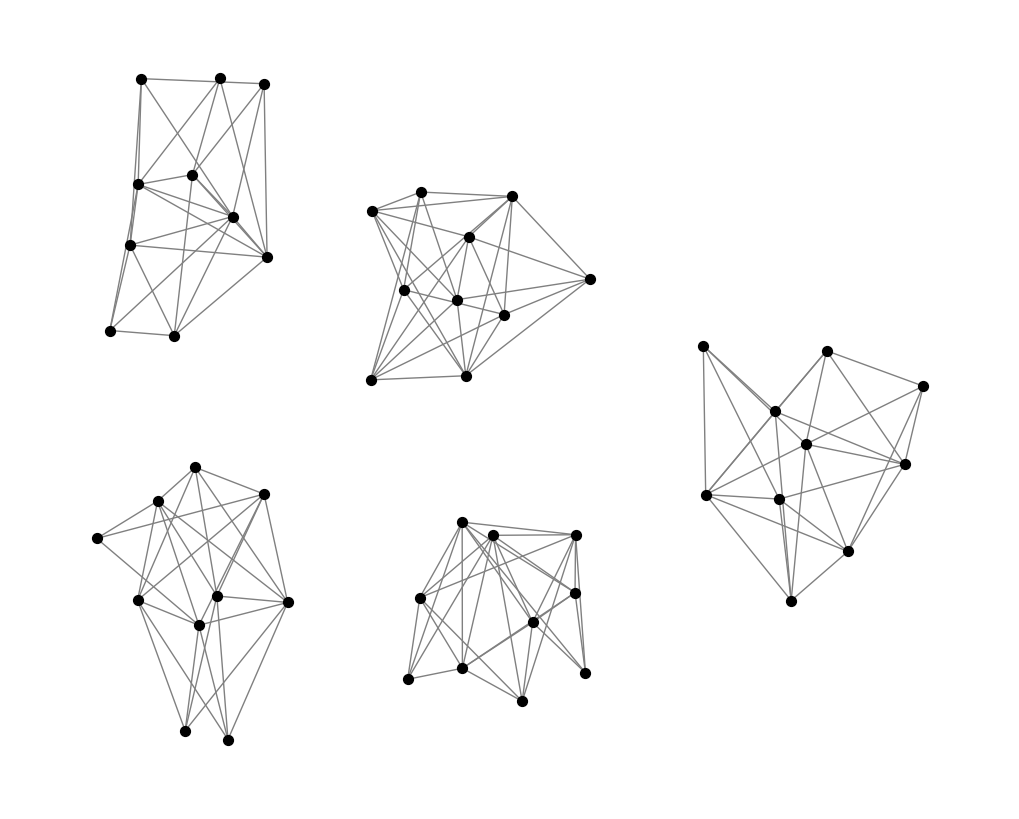

In [58]:
L = nx.normalized_laplacian_matrix(G).toarray()

# Calcular los primeros k vectores propios (omitiendo el primero)
k = 5  # Número de comunidades deseadas
_, eigenvectors = eigsh(L, k=k+1, which='SM')

# Aplicar k-means en los vectores propios para obtener las comunidades
kmeans = KMeans(n_clusters=k, random_state=0).fit(eigenvectors[:, 1:])
clusters = kmeans.labels_
# Now we can color the nodes according to their cluster
plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_size=500, node_color=clusters, cmap='tab10', edge_color='gray', with_labels=True)
plt.show()
# Now we pass the adjacency matrix to a edge_index format
edge_index = torch.tensor(list(G.edges)).t().contiguous()
# Now we remove those edges that are connecting nodes from different communities
mask = clusters[edge_index[0]] == clusters[edge_index[1]]
new_edge_index = edge_index[:, mask]
# Let's plot the new graph
G = nx.Graph()
G.add_edges_from(new_edge_index.t().tolist())
plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_size=50, node_color='black', edge_color='gray', with_labels=False)
plt.show()


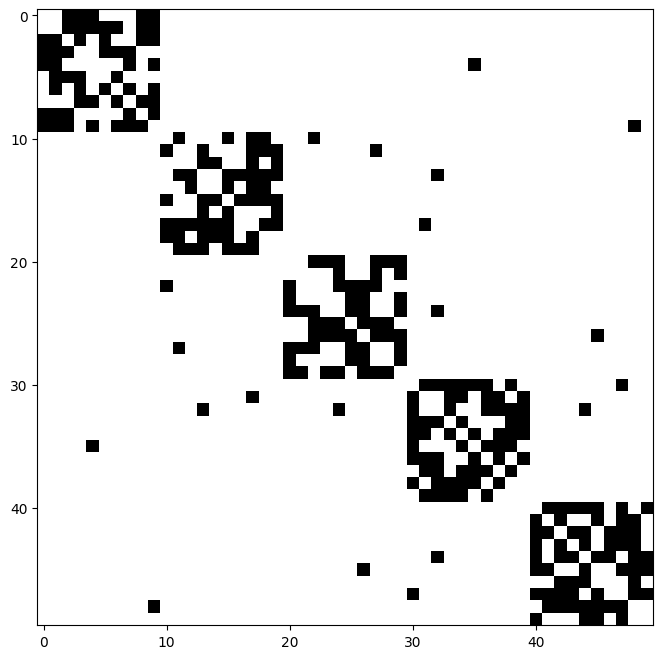

In [18]:
# Let's print the adjacency matrix
A = nx.to_numpy_array(G)
plt.figure(figsize=(10, 8))
plt.imshow(A, cmap='Greys')
plt.show()

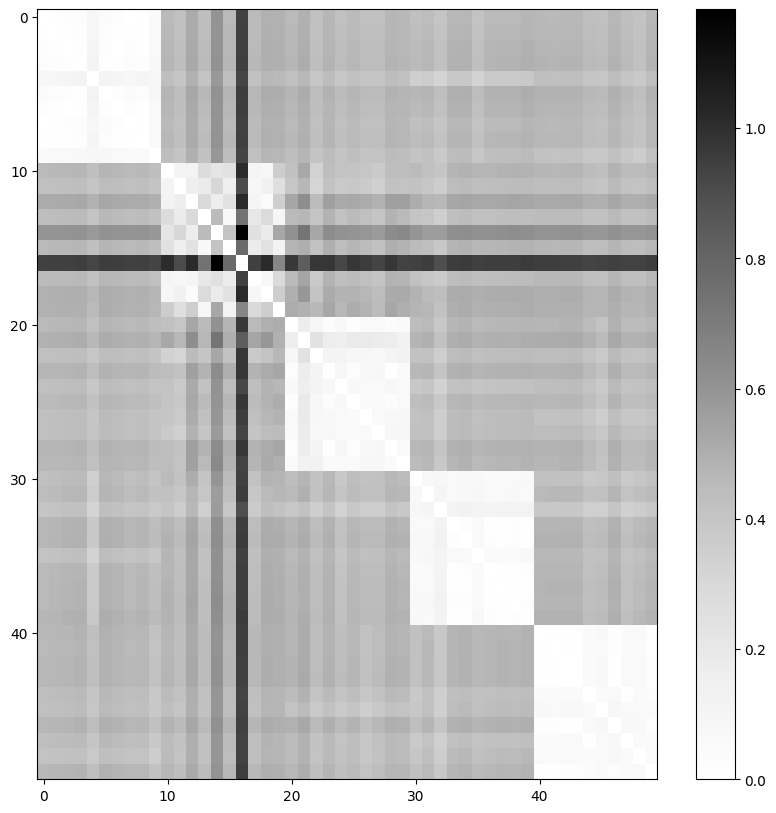

In [38]:
diffussion_map = torch.cdist(torch.tensor(eigenvectors[:, 1:]), torch.tensor(eigenvectors[:, 1:]), p=2)
plt.figure(figsize=(10, 10))
# inside the imshow, we can vizualize the values of the diffussion map
plt.imshow(diffussion_map, cmap='Greys', interpolation='none', aspect='auto')
# Las yticks y xticks son los nodos del grafo y van de 1 en 1
#plt.xticks(ticks=range(50), labels=range(1, 51, 1))
plt.colorbar()
plt.show()

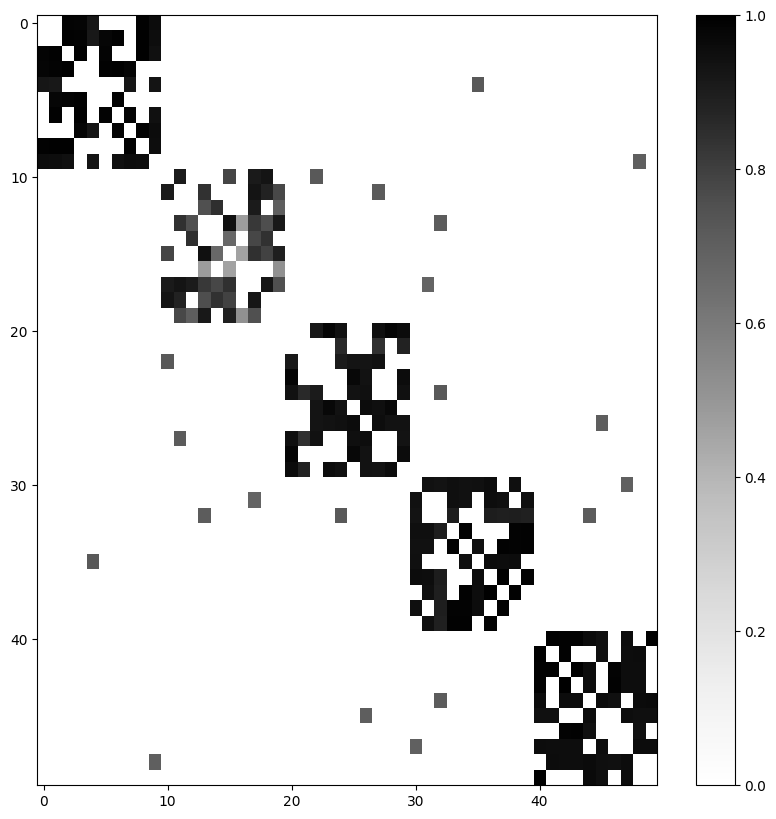

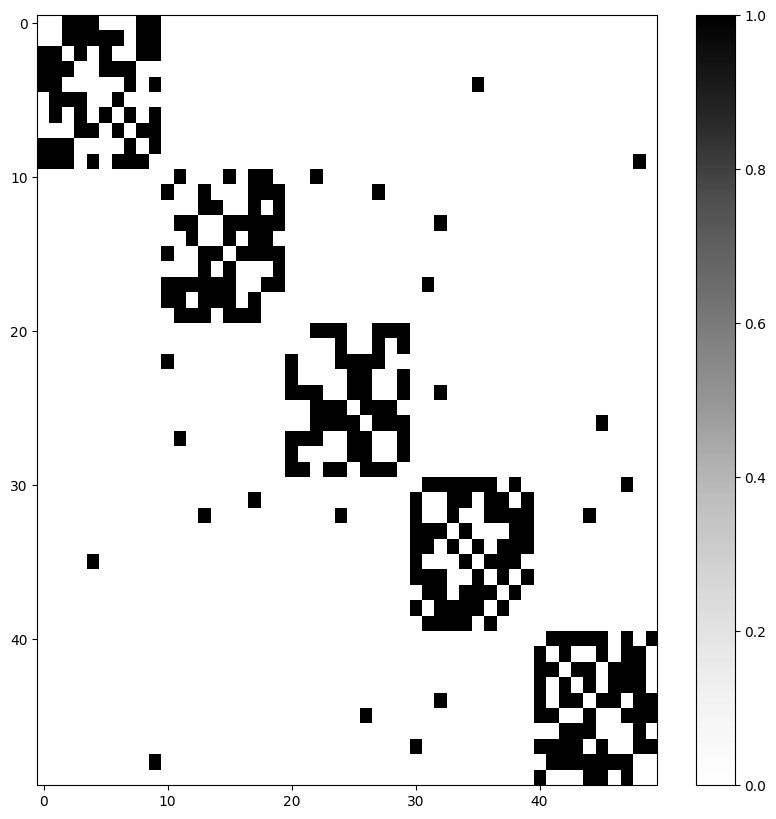

In [45]:
diffussion_map_masked = torch.exp(-diffussion_map) * A
# Normalizamos la matriz de difusión entre 0 y 1
diffussion_map_masked = (diffussion_map_masked - diffussion_map_masked.min()) / (diffussion_map_masked.max() - diffussion_map_masked.min())
avg_diffussion_map = diffussion_map_masked.mean()
plt.figure(figsize=(10, 10))
plt.imshow(diffussion_map_masked, cmap='Greys', interpolation='none', aspect='auto')
plt.colorbar()
plt.show()
diffussion_map_masked_threshold = diffussion_map_masked > avg_diffussion_map
plt.figure(figsize=(10, 10))
plt.imshow(diffussion_map_masked_threshold, cmap='Greys', interpolation='none', aspect='auto')
plt.colorbar()
plt.show()